In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [2]:
dir(transforms)

['AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'autoaugment',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

In [3]:
# writer = SummaryWriter("runs/cifar10")

In [4]:
cifar10_train = datasets.CIFAR10('../../downloads/cifar10', train=True, transform=transforms.ToTensor())
cifar10_value = datasets.CIFAR10('../../downloads/cifar10', train=False, transform=transforms.ToTensor())

In [5]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

(<matplotlib.image.AxesImage at 0x1a39731c670>, 'truck')

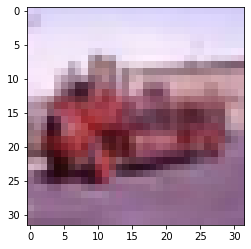

In [6]:
img,label = cifar10_train[67]
plt.imshow(img.permute(1,2,0)),classes[label]


In [7]:
imgs = torch.stack([img for img,_ in cifar10_train], 3)

In [8]:
imgs = imgs.view(3,-1)
imgs.shape

torch.Size([3, 51200000])

In [9]:
mean = imgs.mean(dim=1)
mean

tensor([0.4914, 0.4822, 0.4465])

In [10]:
std = imgs.std(dim=1)
std

tensor([0.2470, 0.2435, 0.2616])

In [11]:
cifar10_t = datasets.CIFAR10('../../downloads/cifar10', train=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))]))
cifar10_v = datasets.CIFAR10('../../downloads/cifar10', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<matplotlib.image.AxesImage at 0x1a3967c62b0>, 'truck')

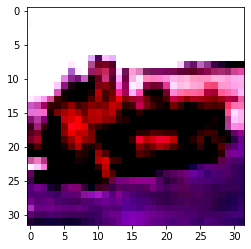

In [12]:
img,label = cifar10_t[67]
plt.imshow(img.permute(1,2,0)),classes[label]

In [13]:
import torch.nn.functional as F
import datetime

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(16, 20, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(20, 20, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(4*4*20, 10)
    def forward(self, x):
        out = F.max_pool2d(F.relu(self.conv1(x)),2)
        out = F.max_pool2d(F.relu(self.conv2(out)),2)
        out = F.max_pool2d(F.relu(self.conv3(out)),2)
        out = out.view(-1, 4*4*20)
        out = self.fc1(out)
        return out
        

In [16]:
train_loader = torch.utils.data.DataLoader(cifar10_t, batch_size=2, shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar10_v, batch_size=2, shuffle=False)

In [17]:
# examples = iter(train_loader)
# example_data, example_target = next(examples)
# print(example_data.shape)
# img_grid = torchvision.utils.make_grid(example_data)
# writer.add_image('cifar10_images', img_grid)
# writer.close()


In [19]:
model = Net()
# writer.add_graph(model, example_data)
# writer.close()

In [37]:
def training(n_epochs, model, optimizer, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        net_loss=0.0
        for imgs,labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            output = model(imgs)
            loss = loss_fn(output, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            net_loss+=loss.item()
        if epoch==1 or epoch%10==0:
            print(f'Time: {datetime.datetime.now()} Epoch: {epoch} Loss: {net_loss/len(train_loader)}')

In [19]:
def validation(model, train_loader, val_loader):
    for name,loader in [('training',train_loader), ('validation',test_loader)]:
        correct=0
        total=0
        with torch.no_grad:
            for imgs,labels in loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                output = model(imgs)
                _,predicted = output.max(dim=1)
                correct += int((predicted==labels).sum())
                total+=len(labels)
            accuracy = correct/total
            print(f'{name} : {accuracy}')

In [96]:
n_epochs = 100
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-4, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()

In [97]:
training(n_epochs, model, optimizer, loss_fn, train_loader)

Time: 2021-10-21 19:29:36.793549 Epoch: 1 Loss: 2.2624014054489137
Time: 2021-10-21 19:38:08.718434 Epoch: 10 Loss: 1.3141278856831788
Time: 2021-10-21 19:47:42.674061 Epoch: 20 Loss: 1.014064262058977
Time: 2021-10-21 20:00:05.345440 Epoch: 30 Loss: 0.8839048056271392
Time: 2021-10-21 20:08:43.434989 Epoch: 40 Loss: 0.805069047476307
Time: 2021-10-21 20:21:54.562532 Epoch: 50 Loss: 0.7461914205536787
Time: 2021-10-21 20:31:07.040306 Epoch: 60 Loss: 0.698374562701112
Time: 2021-10-21 20:40:13.871005 Epoch: 70 Loss: 0.6582317719379839
Time: 2021-10-21 20:48:52.614385 Epoch: 80 Loss: 0.6240888015221312
Time: 2021-10-21 20:57:18.364822 Epoch: 90 Loss: 0.593132231529803
Time: 2021-10-21 21:05:44.538696 Epoch: 100 Loss: 0.5651829540880388


In [98]:
validation(model, train_loader, test_loader)

training : 0.81524
validation : 0.7139


In [20]:
torch.save(model.state_dict(), './cifar10')

In [21]:
loaded_model = Net().to(device='cpu')
loaded_model.load_state_dict(torch.load('./cifar10', map_location='cpu'))

<All keys matched successfully>

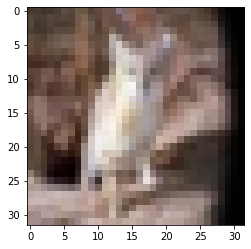

In [22]:
img,label = cifar10_value[127]
plt.imshow(img.permute(1,2,0)),classes[label]
img,_ = cifar10_v[127]

In [38]:
with torch.no_grad():
    index = loaded_model(img.unsqueeze(0))
    index = F.softmax(index, dim=1)[0]
    index = [(value.item()*100,classes[i]) for i,value in enumerate(index)]
index = sorted(index, key=lambda x:x[0], reverse=True)
index

[(86.86314821243286, 'cat'),
 (12.037186324596405, 'dog'),
 (0.43433206155896187, 'horse'),
 (0.40321541018784046, 'frog'),
 (0.24616646114736795, 'bird'),
 (0.011507506860652938, 'deer'),
 (0.0018197712051915005, 'plane'),
 (0.0013441462215268984, 'truck'),
 (0.00117121289804345, 'ship'),
 (0.00010685366760299075, 'car')]

In [26]:
x = loaded_model.conv1

In [31]:
x.

Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

In [140]:
sum(p.numel() for p in loaded_model.parameters())

22466

In [ ]:
##first run
#see 6010
